## Aggregate traffic data to grid and compare gridded traffic with gridded NOx data

In [1]:
!pip install geopandas==0.9.0 -q

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely as shp
import matplotlib.pyplot as plt
import xarray as xr
import shutil

In [3]:
da = xr.DataArray(coords=[np.arange(4,10,0.25), np.arange(43,49,0.25)], dims=['lon', 'lat'])

In [4]:
da.data = np.reshape(values, (24,24)).T

NameError: name 'values' is not defined

In [ ]:
da.plot()

In [5]:
%%time 

sindex = traffic.sindex
values = []

xstep = da.lon

for lon in da.lon.values:
    print(lon)
    for lat in da.lat.values:
        geom = shp.geometry.Point(lon, lat).buffer(0.125).envelope
        possible = list(sindex.intersection(geom.bounds))
        pdf = traffic.iloc[possible]
        clipped = gpd.clip(pdf, geom)
        values.append(clipped.length.sum())

NameError: name 'traffic' is not defined

In [59]:
da['new'] = (('lon', 'lat'), np.reshape(values, (24,24)))

In [72]:
da.assign(new=values)

AttributeError: 'DataArray' object has no attribute 'assign'

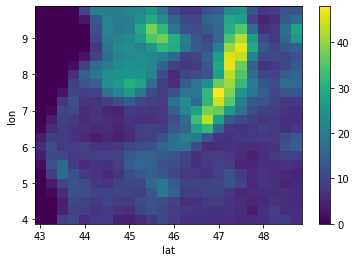

In [69]:
xr.DataArray(data=np.reshape(values, (24,24)), coords=[np.arange(4,10,0.25), np.arange(43,49,0.25)], dims=['lon', 'lat'])

#### Load NOx data

In [5]:
nox = xr.open_dataset('./data/nox/coco_hourly_study_region.nc')['EMISSIONS_2019']
nox

<xarray.DataArray 'EMISSIONS_2019' (time: 720, latitude: 60, longitude: 61)>
[2635200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 4.0 4.1 4.2 4.3 4.4 ... 9.6 9.7 9.8 9.9 10.0
  * latitude   (latitude) float32 43.05 43.15 43.25 43.35 ... 48.75 48.85 48.95
  * time       (time) datetime64[ns] 2019-05-01 ... 2019-05-30T23:00:00
Attributes:
    standard_name:  NOx_EMISSIONS_2019
    long_name:      NOX_EMISSIONS_2019
    units:          kg m-2 s-1

#### Create grid based on NOx data coordinates

In [6]:
grid = nox.mean('time').to_dataframe().reset_index()
grid['latitude'] = np.round(grid.latitude, decimals=2)
grid = gpd.GeoDataFrame(grid, geometry=gpd.points_from_xy(grid.longitude, grid.latitude))
grid.geometry = grid.buffer(0.05).envelope
grid.crs = 'epsg:4326'
grid.head()

,latitude,longitude,EMISSIONS_2019,geometry
0,43.05,4.0,3.410211e-12,"POLYGON ((3.95000 43.00000, 4.05000 43.00000, ..."
1,43.05,4.1,6.091832e-12,"POLYGON ((4.05000 43.00000, 4.15000 43.00000, ..."
2,43.05,4.2,2.365509e-12,"POLYGON ((4.15000 43.00000, 4.25000 43.00000, ..."
3,43.05,4.3,3.209276e-12,"POLYGON ((4.25000 43.00000, 4.35000 43.00000, ..."
4,43.05,4.4,4.465190e-12,"POLYGON ((4.35000 43.00000, 4.45000 43.00000, ..."


#### Load traffic data

In [7]:
traffic = gpd.read_file('data/traffic/4_43_10_49/20210714_0917.zip')
traffic

,DE,PC,QD,LE,speed,JF,geometry
0,Dietfurt,10194,+,0.23058,60.00,53.0,"MULTILINESTRING ((9.08232 47.34337, 9.08233 47..."
1,Aeuli-Tunnel,27519,+,1.14372,73.02,79.2,"MULTILINESTRING ((9.08185 47.34134, 9.08176 47..."
2,Flooz-Tunnel,27518,+,0.52236,76.47,80.0,"MULTILINESTRING ((9.08018 47.33156, 9.08024 47..."
3,Flooz,10192,+,1.59761,78.49,79.9,"MULTILINESTRING ((9.08048 47.32687, 9.08050 47..."
4,Wattwil-Tunnel,27517,+,2.14947,77.49,80.0,"MULTILINESTRING ((9.07965 47.31284, 9.07954 47..."
...,...,...,...,...,...,...,...
75667,Ventabren,4628,-,3.00811,59.29,55.4,"MULTILINESTRING ((5.25970 43.54231, 5.25982 43..."
75668,D543,4629,-,4.75630,63.98,63.6,"MULTILINESTRING ((5.29358 43.54721, 5.29460 43..."
75669,Éguilles est,4630,-,1.54228,50.50,55.3,"MULTILINESTRING ((5.35078 43.54407, 5.35104 43..."
75670,Célony ouest,4631,-,4.14452,52.90,51.3,"MULTILINESTRING ((5.36887 43.54193, 5.36905 43..."


#### Aggregate traffic data to this grid

In [7]:
%%time 

sindex = traffic.sindex
# traffic = traffic.set_crs('epsg:4326')

CPU times: user 5.79 s, sys: 84.2 ms, total: 5.87 s
Wall time: 5.87 s


In [186]:
%%time 

for index, row in grid.iterrows():
    if index%40==0:
        print(index)
    geom = grid.iloc[index:index+1]
    possible = list(sindex.intersection(geom.total_bounds))
    pdf = traffic.iloc[possible]
    clipped = gpd.clip(pdf, geom)
    grid.loc[index, 'traffic'] = (clipped.length).sum()

0


<timed exec>:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326



40
80
120
160
200
CPU times: user 21.6 s, sys: 228 ms, total: 21.8 s
Wall time: 21.8 s


#### Correlation between traffic and emissions

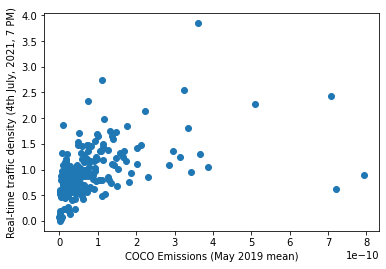

In [193]:
plt.scatter(grid.EMISSIONS_2019, grid.traffic)
plt.xlabel('COCO Emissions (May 2019 mean)')
plt.ylabel('Real-time traffic density (4th July, 2021, 7 PM)')
plt.savefig('Traffic_emissions_correlation.png', dpi=240)

In [191]:
import scipy.stats as ss

In [192]:
r = ss.pearsonr(grid.EMISSIONS_2019, grid.traffic)[0]
print("Correlation coefficient R = %.3f"%(r))

Correlation coefficient R = 0.455


#### Temporal variation

In [98]:
import os
from datetime import datetime as dt

In [99]:
nox_hourly = nox.groupby(nox.time.dt.hour).mean()

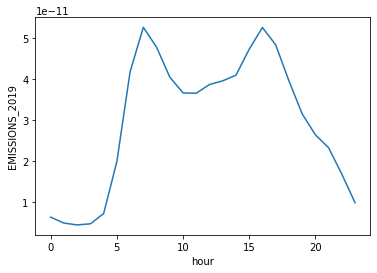

In [100]:
nox_hourly.mean(['latitude', 'longitude']).plot()

In [101]:
def agg_to_grid(da, gdf, timestep=None, var_name='new_var'):
    'Aggregate geodataframe of points or lines to grid defined by xarray DataArray.'
    
#     if gdf.crs == None:
#         gdf = gdf.set_crs('epsg:4326')
    if type(da) == xr.DataArray:
        print('Converting to Xarray Dataset')
        da = da.to_dataset(name='emissions')
        da[var_name] = xr.zeros_like(da['emissions'])
        
    if 'x' in da.dims:
        coords = ['x','y']
    elif 'lon' in da.dims:
        coords = ['lon', 'lat']
    elif 'longitude' in da.dims:
        coords = ['longitude', 'latitude']

    lons = da[coords[0]].values
    lats = da[coords[1]].values
    
    sindex = gdf.sindex
    
    xstep = da[coords[0]][1].values - da[coords[0]][0].values
    ystep = da[coords[1]][1].values - da[coords[1]][0].values
    
    assert (xstep - ystep)/xstep < 0.001, 'Grid is not square'

    for lon in da[coords[0]].values:
#         print(lon)
        for lat in da[coords[1]].values:
            geom = shp.geometry.Point(lon, lat).buffer(xstep/2.).envelope
            possible = list(sindex.intersection(geom.bounds))
            pdf = gdf.iloc[possible]
            
            clipped = gpd.clip(pdf, geom)
            length = (clipped.LE * clipped.speed).sum()
            if timestep != None:
                da[var_name].loc[timestep, lat, lon] = length
            else:
                da[var_name].loc[lat, lon] = length

    return da

In [102]:
%%time

files = os.listdir('./data/traffic/4_43_10_49/')
tests = []
for hour in range(24):
    gdfs = []
    
    hour_files = [x for x in files if (int(x[-8:-6]) ==  hour) & (int(x[-11:-9]) > 14)]

    if len(hour_files)>0:
        print(hour_files[0])
        gdf = gpd.read_file('./data/traffic/4_43_10_49/%s'%hour_files[0])

        nox_hourly = agg_to_grid(nox_hourly, gdf, timestep=hour, var_name='traffic')
#         tests.append(agg_to_grid(nox_hourly, gdf, timestep=hour, var_name='traffic'))

20210715_0013.zip
Converting to Xarray Dataset
20210715_0113.zip
20210715_0213.zip
20210715_0556.zip
20210715_0611.zip
20210715_0729.zip
20210715_0814.zip
20210715_0914.zip
20210715_1014.zip
20210715_1113.zip
20210716_1227.zip
20210716_1312.zip
20210716_1412.zip
20210716_1512.zip
20210715_2110.zip
20210715_2210.zip
20210715_2310.zip
CPU times: user 36min 8s, sys: 1.67 s, total: 36min 10s
Wall time: 36min 51s


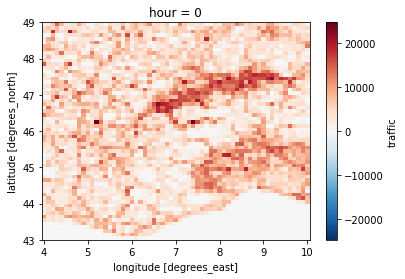

In [105]:
nox_hourly['traffic'].isel(hour=0).plot()

In [109]:
nox_hourly.to_netcdf('./data/emissions_traffic_hourly_merged.nc')

In [113]:
hourwise = nox_hourly.mean(['latitude', 'longitude'])

In [134]:
df = nox_hourly.to_dataframe()

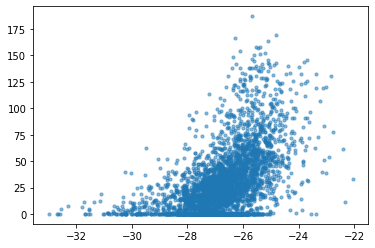

In [146]:
plt.scatter(np.log(df.emissions), df.traffic, s=10, alpha=0.5)

In [137]:
import scipy.stats as ss

In [138]:
r = ss.pearsonr(np.log(df.emissions), df.traffic)[0]
print("Correlation coefficient R = %.3f"%(r))

Correlation coefficient R = 0.283


In [140]:
for hour in range(24):
    df_ = df.loc[hour]
    r = ss.pearsonr(np.log(df_.emissions), df_.traffic)[0]
    print('%s \t %.3f'%(hour, r))

0 	 0.502
1 	 0.502
2 	 0.500
3 	 nan
4 	 nan
5 	 0.435
6 	 0.473
7 	 0.497
8 	 0.499
9 	 0.499
10 	 0.499
11 	 0.501
12 	 0.496
13 	 0.494
14 	 0.489
15 	 0.481
16 	 nan
17 	 nan
18 	 nan
19 	 nan
20 	 nan
21 	 0.507
22 	 0.501
23 	 0.499
